# Observed discharge
***

__Author__: Chus Casado<br>
__Date__:   08-06-2022<br>

__Introduction__:<br>


In [3]:
import os
path_root = os.getcwd()
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

os.chdir('../py/')
from convert import dict2da
os.chdir(path_root)

In [52]:
def KGE(observado, simulado, sa=1, sb=1, sr=1):
    """Calcula el coeficiente de eficiencia de Kling-Gupta.
    
    Parámetros:
    -----------
    observado:   series. Serie observada
    simulado:    series. Serie simulada
    sa, sb, sr: integer. Factores de escala de los tres términos del KGE: alpha, beta y coeficiente de correlación, respectivamente
    
    Salida:
    -------
    KGE:        float. Eficienica de Kling-Gupta"""
    
    # Eliminar pasos sin dato
    data = pd.concat((observado, simulado), axis=1)
    data.columns = ['obs', 'sim']
    data.dropna(axis=0, how='any', inplace=True)
    # Para la función si no hay datos
    if data.shape[0] == 0:
        return

    # calcular cada uno de los términos del KGE
    alpha = data.sim.std() / data.obs.std()
    beta = data.sim.mean() / data.obs.mean()
    r = np.corrcoef(data.obs, data.sim)[0, 1]
    
    # Cacular KGE
    ED = np.sqrt((sr * (r - 1))**2 + (sa * (alpha - 1))**2 + (sb * (beta - 1))**2)
    KGE = 1 - ED
    
    return KGE

## 2 Data
### 2.1 Reporting points

In [72]:
stations = pd.read_parquet('../results/reporting_points/reporting_points_over_500km2.parquet')
stations = stations[['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country', 'n_events_obs', 'rl5', 'rl20', 'rl100']]

In [71]:
stations.sort_values('n_events_obs', ascending=False).head(29)

name          X          Y  \
id                                                                              
2996                                          Burguillo  3097500.0  2042500.0   
2390                                        RUSHES LOCK  3677500.0  3222500.0   
4292                                          Contreras  3332500.0  1902500.0   
1469                                            Rabaçal  2802500.0  2267500.0   
1454                                     Ponte Da Barca  2797500.0  2267500.0   
1569                 River Lee At Feildes Weir (Gauged)  3632500.0  3232500.0   
1572                            Feildes Weir Ultrasonic  3632500.0  3227500.0   
1688                              Lakhish-Ad Halom Park  6647500.0  1347500.0   
4001                                             Permet  5202500.0  1962500.0   
2275                                     AGAN NAHARAYIM  6707500.0  1467500.0   
4324                                             Arenos  3417500.0  1952500.0   
2388                                            Blunham  3617500.0  3272500.0   
2999                                    Gabriel y Galan  2947500.0  2042500.0   
1573                                         Lea Bridge  3627500.0  3212500.0   
187                                               Lienz  4527500.0  2642500.0   
3166              La Sioule à Saint-Pourçain-sur-Sioule  3802500.0  2602500.0   
223                                   Hart im Zillertal  4462500.0  2692500.0   
2951  La Sioule a Saint-Priest-des-Champs [Fades-Bes...  3767500.0  2567500.0   
1568                              Hoddesdon, Rye Bridge  3632500.0  3237500.0   
1580                                         Tinwell Gs  3612500.0  3332500.0   
1680                              Jordan - Sede Nehemya  6687500.0  1522500.0   
4627                    Río Zadorra en Vitoria-Abetxuko  3292500.0  2282500.0   
1194                                             Tormes  3007500.0  2057500.0   
2707                                            EYVAZLI  7337500.0  2562500.0   
4174                           Turano a Rocca Sinibalda  4562500.0  2137500.0   
2701                                         NAMOKHVANI  6927500.0  2727500.0   
3018                                           Almendra  2957500.0  2167500.0   
310                                                Lalm  4277500.0  4307500.0   
1529                                           Kearsley  3507500.0  3452500.0   

         area       subcatchment     river   catchment country  n_events_obs  \
id                                                                             
2996   1075.0           Alberche  Alberche       Tagus      ES            12   
2390   1025.0            Chelmer   Chelmer     Chelmer      UK             7   
4292   3400.0            Cabriel   Cabriel       Jucar      ES             7   
1469   2075.0               Lima      Lima        Lima      PT             7   
1454   2100.0               Lima      Lima        Lima      PT             7   
1569   1125.0                Lee       Lee      Thames      UK             7   
1572   1175.0                Lee       Lee      Thames      UK             7   
1688   1025.0            Lakhish   Lakhish     Lakhish      IL             7   
4001   2900.0              Vjosa     Vjosa       Vjosa      AL             6   
2275  53050.0  Jordan / Dead Sea    Jordan      Jordan      JO             6   
4324   1450.0            Mijares   Mijares     Mijares      ES             6   
2388    500.0         Great Ouse      Ivel  Great Ouse      UK             6   
2999   2425.0              Tagus    Alagon       Tagus      ES             6   
1573   1400.0                Lee       Lee      Thames      UK             6   
187    1200.0              Drava      Isel      Danube      AT             5   
3166   2475.0             Allier    Sioule       Loire      FR             5   
223    1175.0                Inn    Ziller      Danube      AT             5   
2951   1350.0      

### 2.2 Discharge
#### 2.2.1 Observed
**Near real time operational**

In [74]:
data = pd.read_csv('../data/discharge/observed/output-6h-nrt-operational.txt', index_col='Station ID', na_values=[-9999, -999, -99])
data.Timestamp = pd.to_datetime(data.Timestamp)
stns = data.index.unique().tolist()
stns.sort()
dates = pd.date_range(datetime(2018, 1, 1), data.Timestamp.max() + timedelta(hours=1), freq='6h')
obs = pd.DataFrame(index=dates, columns=stns, dtype=float)
for i, stn in enumerate(stns):
    
    print(f'{i+1:02d} from {len(stns):02d}', end='\r')
    
    aux = data.loc[stn, ['Timestamp', 'AvgValue']]
    aux.set_index('Timestamp', drop=True, inplace=True)
    aux = aux.loc['2018-01-01':, 'AvgValue']
    aux[(aux < 0) | (aux > 10000)] = np.nan
    obs.loc[aux.index, stn] = aux.values

**Historical operational**

In [76]:
path_obs = '../data/discharge/observed/historic_operational/'

json_files = glob.glob(f'{path_obs}*.json')

obs = pd.DataFrame(dtype=float)
for file in json_files:
    df = pd.read_json(file)
    stn = df['Station ID'].unique()[0]
    df = df[['Timestamp', 'AvgValue']]
    df.set_index('Timestamp', drop=True, inplace=True)
    df.columns = [stn]
    obs = pd.concat((obs, df), axis=1)
    
    

obs.head()

71     73     74     75       76       78     79    \
Timestamp                                                                  
2021-01-01 00:00:00  7.548  4.952  5.841  9.629  226.708  227.000  6.920   
2021-01-01 06:00:00  7.468  4.965  5.788  9.789  224.125  227.000  7.291   
2021-01-01 12:00:00  7.595  4.917  5.851  9.430  220.792  227.000  7.472   
2021-01-01 18:00:00  7.414  4.844  5.800  9.231  218.667  225.708  7.283   
2021-01-02 00:00:00  7.555  4.843  5.724  9.430  214.875  225.000  7.489   

                       187     223     310   ...    1194   1568   1572   1573  \
Timestamp                                    ...                                
2021-01-01 00:00:00  15.730  19.091  55.612  ...  20.090  5.826  9.336  5.088   
2021-01-01 06:00:00  13.640  13.824  55.987  ...  20.185  5.671  9.135  4.517   
2021-01-01 12:00:00  13.004  11.901  56.267  ...  19.368  5.584  8.688  3.462   
2021-01-01 18:00:00  14.899  12.470  56.547  ...  19.080  5.413  8.397  4.813   
2021-01-02 00:00:00  16.680  36.682  57.022  ...  18.973  5.387  8.475  4.319   

                      1580    3166  4174   4292   4324  4627  
Timestamp                                                     
2021-01-01 00:00:00  3.148  26.788   NaN  1.269  4.813   NaN  
2021-01-01 06:00:00  2.079  28.507   NaN  1.272  4.802   NaN  
2021-01-01 12:00:00  1.750  31.054   NaN  1.270  4.811   NaN  
2021-01-01 18:00:00  2.781  22.742   NaN  1.263  4.806   NaN  
2021-01-02 00:00:00  2.303  22.972   NaN  1.271  4.822   NaN  

[5 rows x 21 columns]

#### 2.2.2 Reanalysis

In [77]:
path_reanalysis = '../data/discharge/reanalysis/'
rean = pd.DataFrame({stn: xr.open_dataarray(f'{path_reanalysis}{stn:04}.nc').to_pandas() for stn in obs.columns})

In [60]:
# rea = pd.DataFrame(dtype=float)
# files = glob.glob('../data/discharge/reanalysis/*.csv')
# for file in files:
#     aux = pd.read_csv(file, parse_dates=True, index_col=0)
#     aux.columns = aux.columns.astype(int)
#     rea = pd.concat((rea, aux), axis=0)

## Comparison

In [ ]:
# cut series so that they have the same extent
start = max(obs.index.min(), rea.index.min())
end = min(obs.index.max(), rea.index.max())
obs = obs.loc[start:end,:]
rea = rea.loc[start:end,:]

In [67]:
kge = pd.Series({stn: KGE(obs[stn], rean[stn]) for stn in obs.columns})

In [ ]:
kge.sort_values()

In [68]:
stn = kge.idxmin()
print(stn)

954


name            Embalse de Benínar
X                        3157500.0
Y                        1637500.0
area                         500.0
subcatchment                  Adra
river                    Lucainena
catchment                     Adra
country                         ES
n_events_obs                     4
rl5                           23.1
rl20                          37.9
rl100                         54.3
Name: 954, dtype: object

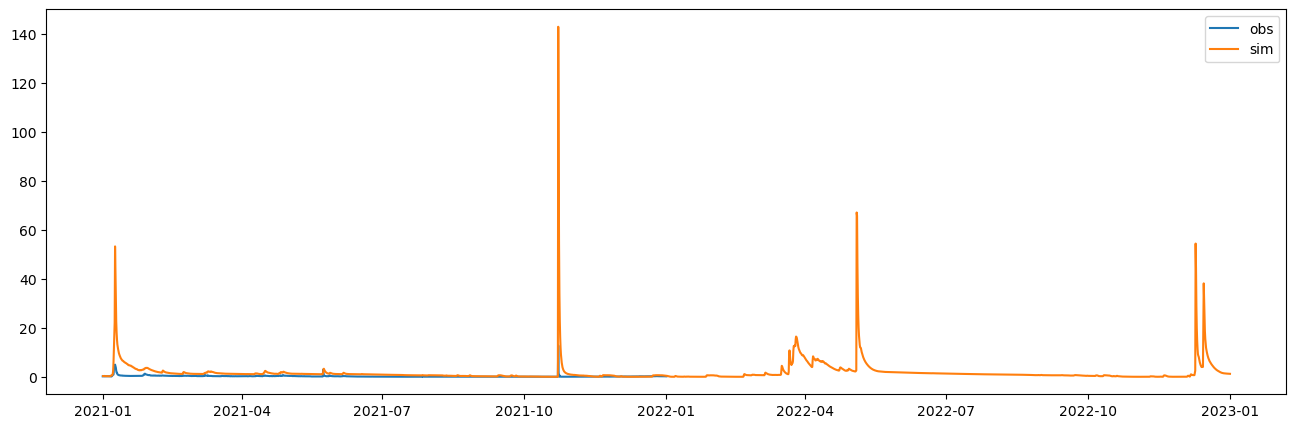

In [69]:
# stn = '2996'

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(obs.index, obs[stn], label='obs')
ax.plot(rean.index, rean[stn], label='sim')
ax.legend();

stations.loc[stn]

In [ ]:
rea.plot(figsize=(16, 5));

***

Analyse the availability of data in the Hydro Database.

**Historical**

In [ ]:
historic_operational = pd.read_excel('../data/discharge/observed/DB/OP_hdata_ranges_EHDCC_8029.xlsx', sheet_name='6h', header=0, index_col=0)
historic = pd.read_csv('../data/discharge/observed/DB/hdata_ranges_EHDCC_8029_202305151428_EFAS3_Hydro_ro.csv', sep=';', parse_dates=True, index_col='ID')

print('no. points with historic operational data:\t{0}'.format(historic_operational.shape[0]))
print('no. points with historic data:\t\t\t{0}'.format(historic.shape[0]))

**Real time**

In [ ]:
real_time_operational = pd.read_excel('../data/discharge/observed/DB/OP_rtdata_ranges_EHDCC_8029.xlsx', sheet_name='6h', header=0, index_col=0)
real_time = pd.read_csv('../data/discharge/observed/DB/rtdata_ranges_EHDCC_8029_202305151623_EFAS3_Hydro_ro.csv', sep=';', parse_dates=True, index_col='ID')

print('no. points with real time operational data:\t{0}'.format(real_time_operational.shape[0]))
print('no. points with real time data:\t\t\t{0}'.format(real_time.shape[0]))

In [ ]:
print('no. stations in both historic and real time data:', len(set(historic.index).intersection(real_time.index)))
print('no. stations in both historic operational and real time data operational:', len(set(historic_operational.index).intersection(real_time_operational.index)))

In [ ]:
stns = [2996,
 1569,
 1469,
 1454,
 1688,
 1572,
 4292,
 2390,
 2275,
 2999,
 4324,
 2388,
 4001,
 1573,
 2951,
 3018,
 2707,
 1680,
 3166,
 1580,
 4627,
 310,
 4174,
 187,
 223,
 1568,
 2701,
 1194,
 3017,
 4114,
 2997,
 4490,
 4015,
 4500,
 4013,
 4504,
 4578,
 2685,
 119,
 2596,
 2428,
 166,
 167,
 195,
 247,
 578,
 581,
 954,
 1410,
 1411,
 1529,
 1652,
 1653,
 1737,
 1738,
 2016,
 165,
 2149,
 2341,
 2373,
 2148]

In [ ]:
for stn in stns:
    if stn in historic.index:
        print(stn, 'historic', *historic.loc[stn, ['start', 'end']], sep='\t')
    if stn in historic_operational.index:
        print(stn, 'historic op.', *historic_operational.loc[stn, ['start', 'end']], sep='\t')
    if stn in real_time.index:
        print(stn, 'real time', *real_time.loc[stn, ['start', 'end']], sep='\t')
    if stn in real_time_operational.index:
        print(stn, 'real time op.', *real_time_operational.loc[stn, ['start', 'end']], sep='\t')
    print()

In [ ]:
path_hist_op = '../data/discharge/observed/historic_operational/'
files_obs = glob.glob(f'{path_hist_op}*.csv')
stns = [int(file.split('\\')[-1].split('_')[0]) for file in files_obs]

Qobs = pd.DataFrame(index=pd.date_range(datetime(2020, 1, 1), datetime(2023, 1, 1), freq='6h'),
                    columns=stns,
                    dtype=float)
for file, stn in zip(files_obs, stns):
    raw = pd.read_csv(file, parse_dates=True, index_col=0)
    raw.drop_duplicates(keep='first', inplace=True)
    raw = raw.loc[raw.Variable == 'D', 'Value']
    Qobs.loc[raw.index, stn] = raw
    
Qobs = Qobs.loc[Qobs.first_valid_index():Qobs.last_valid_index()]
print(Qobs.shape)
Qobs.head()

<font color='red'>**Negative discharge!!!**</font>

In [ ]:
path_rean = '../data/discharge/reanalysis/'

In [ ]:
xr.open_dataarray(f'{path_rean}{954:04}.nc')

In [ ]:
Qrean = dict2da({stn: xr.open_dataarray(f'{path_rean}{stn:04}.nc') for stn in Qobs.columns}, dim='id').transpose()
Qrean = Qrean.sel(datetime=slice(Qobs.index.min(), Qobs.index.max()))
Qrean = Qrean.to_pandas()

In [ ]:
lw = .7
alpha = .1

fig, axes = plt.subplots(nrows=len(stns), figsize=(16, 3 * len(stns)), sharex=True)

start, end = Qobs.index.min(), Qobs.index.max()

for ax, stn in zip(axes, stns):
    ax.plot(Qobs[stn], c='dimgray', lw=lw, label='observed')
    ax.plot(Qrean[stn], c='steelblue', lw=lw, label='reanalysis')
    ax.fill_between([start, end], *stations.loc[stn, ['rl5', 'rl20']], alpha=alpha, color='red', edgecolor=None)
    ax.fill_between([start, end], *stations.loc[stn, ['rl20', 'rl100']], alpha=alpha, color='purple', edgecolor=None)
    ax.set_title('{0} - River {1} ({2})'.format(stn, *stations.loc[stn, ['river', 'catchment']]))
    ax.set_ylabel('discharge (m3/s)')
    kge = KGE(Qobs[stn], Qrean[stn])
    ax.text(.005, .92, f'KGE = {kge:.2f}', transform=ax.transAxes)
ax.set_xlim(start, end);